# Climate change belief analysis

The purpose of this challenge is to determine how many people believe that Global Warming is real and that the cause of this issue is due to the day to day actions that we, humans endure on a daily basis.

We will work with a given tweet dataset and try to create a machine learning model that can helps us classify whether a person believes or does not believe that climate change is a threat for all of us.


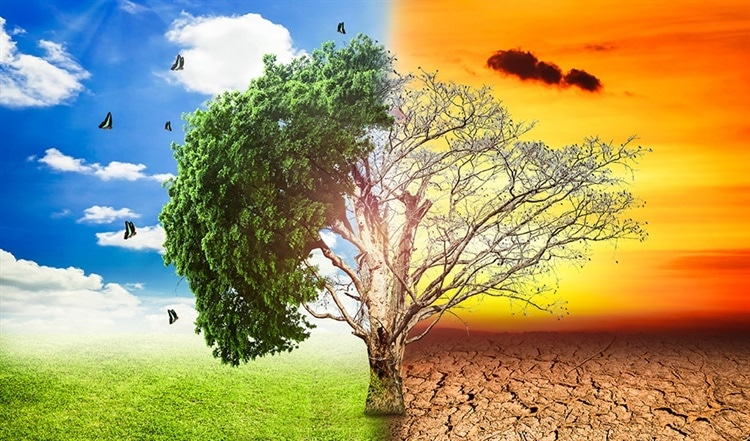

# **We will start by importing all the neccessary libraries and modules that we will need for this challenge**

In [1]:
import numpy as np
import pandas as pd
import nltk
import re
import spacy
import string
import seaborn as sns
import matplotlib.pyplot as plt

import matplotlib.style as style 
sns.set(font_scale=1.5)
from wordcloud import WordCloud


nlp = spacy.load('en')
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('stopwords')
nltk.download('averaged_perceptron_tagger')


import en_core_web_sm
from collections import Counter
from nltk.probability import FreqDist
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer 
from nltk.corpus import stopwords, wordnet  
from sklearn.feature_extraction.text import CountVectorizer   
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import TfidfTransformer 
from sklearn.model_selection import train_test_split, RandomizedSearchCV


from sklearn.svm import LinearSVC
from sklearn.pipeline import Pipeline
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression


from sklearn import metrics
from sklearn.metrics import classification_report, confusion_matrix, f1_score, precision_score, recall_score

[nltk_data] Downloading package punkt to /usr/share/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /usr/share/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /usr/share/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


In [2]:
#import datasets
train = pd.read_csv('../input/climate-change-edsa2020-21/train.csv')
test= pd.read_csv('../input/climate-change-edsa2020-21/test.csv')
sample_sub = ('../input/climate-change-edsa2020-21/sample_submission.csv')

In [3]:
#lets check the data
display(train.head())
display(test.head())

train.sentiment.value_counts()

,sentiment,message,tweetid
0,1,PolySciMajor EPA chief doesn't think carbon di...,625221
1,1,It's not like we lack evidence of anthropogeni...,126103
2,2,RT @RawStory: Researchers say we have three ye...,698562
3,1,#TodayinMaker# WIRED : 2016 was a pivotal year...,573736
4,1,"RT @SoyNovioDeTodas: It's 2016, and a racist, ...",466954


,message,tweetid
0,Europe will now be looking to China to make su...,169760
1,Combine this with the polling of staffers re c...,35326
2,"The scary, unimpeachable evidence that climate...",224985
3,@Karoli @morgfair @OsborneInk @dailykos \nPuti...,476263
4,RT @FakeWillMoore: 'Female orgasms cause globa...,872928


 1    8530
 2    3640
 0    2353
-1    1296
Name: sentiment, dtype: int64

In [4]:
#lets check how many duplicates we have on the train dataset

duplicates = round((1-(train['message'].nunique()/len(train['message'])))*100)
print('Duplicate tweets')
print(duplicates)

Duplicate tweets
10


# Data insights :

The data is divided in 4 classes:

*  *2*  **News** :    Tweets linked to factual news about climate change.
 
*  *1*  **Pro** :     Tweets that support the belief of man-made climate change.
 
*  *0*  **Neutral** : Tweets that neither support nor refuse beliefs of climate change.
 
* *-1* **Anti** :    Tweets that do not support the belief of man-made climate change.

* 10% of the tweets are duplicates in the train data.

# Lets do some more prepocessing before we continue exploring our data.



In [5]:
#create a copy of the train data & rename the classes from numbers to words


def create(df):
    

    df = train.copy()
    sentiment = df['sentiment']
    sent_w = []


    for a in sentiment :
        if a == 1 :
            sent_w.append('Pro')
        elif a == 0 :
            sent_w.append('Neutral')
        elif a == -1 :
            sent_w.append('Anti')
        else :
            sent_w.append('News')
            

    df['sentiment'] = sent_w
    
    return df

df = create(train)
df.head()


,sentiment,message,tweetid
0,Pro,PolySciMajor EPA chief doesn't think carbon di...,625221
1,Pro,It's not like we lack evidence of anthropogeni...,126103
2,News,RT @RawStory: Researchers say we have three ye...,698562
3,Pro,#TodayinMaker# WIRED : 2016 was a pivotal year...,573736
4,Pro,"RT @SoyNovioDeTodas: It's 2016, and a racist, ...",466954


# Next we will extract the hashtags from the dataset

We will extract the hashtags from the original data and store them on a new dataframe so that important information is not lost.

In [6]:
def hash_extraction(tweet):
    
    
    hasht = []
    
    for x in tweet:
        tag=re.findall(r"#(\w+)", x)
        hasht.append(tag)
        
    hasht = sum(hasht,[])
    freq = nltk.FreqDist(hasht)
    
    hashtag_df = pd.DataFrame({'hashtag': list(freq.keys()),
                               'count': list(freq.values())})
    
    
    hashtag_df = hashtag_df.nlargest(20, columns="count")
    
    return hashtag_df

#retrieving the # from tweets in each class

anti = hash_extraction(df['message'][df['sentiment'] == 'Anti'])
neutral = hash_extraction(df['message'][df['sentiment'] == 'Neutral'])
pro = hash_extraction(df['message'][df['sentiment'] == 'Pro'])
news = hash_extraction(df['message'][df['sentiment'] == 'News'])

anti.head()


,hashtag,count
30,MAGA,11
48,climate,10
12,Trump,7
72,climatechange,6
7,OpChemtrails,4


# Text cleaning

We need to remove all the unnecessaty data such as punctuations , urls,& convert all the text to lower case etc..

We will make use of use regular expressions in order to cleanup our data.... lets do this!

In [7]:
def clean_tweets (tweet):
    
    tweet = tweet.lower()  #convert to lower case    
    tweet = re.sub('@[\w]*','',tweet) # remove mentions
    tweet = re.sub(r'#\w*', '', tweet) #removed hashtags
    tweet = re.sub(r'https?:\/\/.*\/\w*', '',tweet ) #remove urls
    tweet = re.sub(r'\d+', '', tweet) #remove numbers
    tweet = re.sub(r"[,.;':@#?!\&/$]+\ *", ' ', tweet) #remove punctuation
    tweet = re.sub(r'\s\s+', ' ', tweet) #remove white spaces
    tweet = tweet.lstrip(' ') #remove space in front of the tweet
    tweet = re.sub(r"U+FFFD ", ' ', tweet) #remove unicode
    
    return tweet
    
    
df['message'] = df['message'].apply(clean_tweets)
df['message'] = df['message'].apply(clean_tweets)

df.head()

,sentiment,message,tweetid
0,Pro,polyscimajor epa chief doesn t think carbon di...,625221
1,Pro,it s not like we lack evidence of anthropogeni...,126103
2,News,rt researchers say we have three years to act ...,698562
3,Pro,wired was a pivotal year in the war on climate...,573736
4,Pro,rt it s and a racist sexist climate change den...,466954


# Parts of speech

Lemmatizing is the process of grouping words of similar meaning together.

We will work with Lemmatization as stemming it's a method for cataloging related words and since English has many exceptions we need something more accurate to get the best resuts.

In [8]:
def lemmat (df):
    
    df['length'] = df['message'].str.len()
    df['tokenized'] = df['message'].apply(word_tokenize)
    df['pos_tags'] = df['tokenized'].apply(nltk.tag.pos_tag)
    
    
    def wordnet_pos(tag):
        
        if tag.startswith('J'):
            return wordnet.ADJ

        elif tag.startswith('V'):
            return wordnet.VERB

        elif tag.startswith('N'):
            return wordnet.NOUN

        elif tag.startswith('R'):
            return wordnet.ADV
    
        else:
            return wordnet.NOUN
        
        
    wl = WordNetLemmatizer()
    df['pos_tags'] = df['pos_tags'].apply(lambda x: [(word, wordnet_pos(pos_tag)) for (word, pos_tag) in x])
    df['lemmatized'] = df['pos_tags'].apply(lambda x: [wl.lemmatize(word, tag) for word, tag in x])
    df['lemmatized'] = [' '.join(map(str, l)) for l in df['lemmatized']]  
    return df

df = lemmat(df)
df.head()
    
    
    

,sentiment,message,tweetid,length,tokenized,pos_tags,lemmatized
0,Pro,polyscimajor epa chief doesn t think carbon di...,625221,102,"[polyscimajor, epa, chief, doesn, t, think, ca...","[(polyscimajor, a), (epa, n), (chief, n), (doe...",polyscimajor epa chief doesn t think carbon di...
1,Pro,it s not like we lack evidence of anthropogeni...,126103,62,"[it, s, not, like, we, lack, evidence, of, ant...","[(it, n), (s, v), (not, r), (like, n), (we, n)...",it s not like we lack evidence of anthropogeni...
2,News,rt researchers say we have three years to act ...,698562,86,"[rt, researchers, say, we, have, three, years,...","[(rt, n), (researchers, n), (say, v), (we, n),...",rt researcher say we have three year to act on...
3,Pro,wired was a pivotal year in the war on climate...,573736,54,"[wired, was, a, pivotal, year, in, the, war, o...","[(wired, v), (was, v), (a, n), (pivotal, a), (...",wire be a pivotal year in the war on climate c...
4,Pro,rt it s and a racist sexist climate change den...,466954,81,"[rt, it, s, and, a, racist, sexist, climate, c...","[(rt, v), (it, n), (s, n), (and, n), (a, n), (...",rt it s and a racist sexist climate change den...


# NES - Name Entity Recogntion

Lets try and extract the top 5 organizations in order to determine the most mentioned people, organizations & geopolitical entities in each of the classes.

In [9]:
def nes(tweet):
    
    def ret_ppl(tweet):
        word = nlp(tweet)
        p = [w.text for w in word.ents if w.label_== 'PERSON']
        return p
    
    def ret_org(tweet):
        word = nlp(tweet)
        orga = [w.text for w in word.ents if w.label_== 'ORG']
        return orga
        
    def ret_geo(tweet):
        word = nlp(tweet)
        geo = [w.text for w in word.ents if w.label_== 'GPE']
        return geo
    
    # extract the top 5 people
    p = tweet.apply(lambda x:  ret_ppl(x)) 
    p = [x for sub in p for x in sub]
    p_counter = Counter(p)
    p_count = p_counter.most_common(5)
    p, p_count = map(list, zip(*p_count))
    
    # extract the top 5 organizations
    orga = tweet.apply(lambda x: ret_org(x)) 
    orga = [x for sub in orga for x in sub]
    orga_counter = Counter(orga)
    orga_count = orga_counter.most_common(5)
    orga, orga_count = map(list, zip(*orga_count))
    
    # extract the top 5 geopolitical entities
    geo = tweet.apply(lambda x: ret_geo(x)) 
    geo = [x for sub in geo for x in sub]
    geo_counter = Counter(geo)
    geo_count = geo_counter.most_common(5)
    geo, geo_count = map(list, zip(*geo_count))
    
    # create a dataframe to store the information
    df = pd.DataFrame({'p' : p})
    df['geopolitics'] = geo
    df['organizations'] = orga
    
    return df

# extract the top entities for each class

anti_ents = nes(df['lemmatized'][df['sentiment']=='Anti'])
pro_ents = nes(df['lemmatized'][df['sentiment']=='Pro'])
news_ents = nes(df['lemmatized'][df['sentiment']=='News'])
neutral_ents = nes(df['lemmatized'][df['sentiment']=='Neutral'])
        


# Find the common words on each class

In [10]:
def common(tweet):
# Count vectorizer excluding english stopwords
    cnt = CountVectorizer(stop_words='english')
    words = cnt.fit_transform(tweet)

    
#count the words in the tweets and get the frequency of each word

    sumw = words.sum(axis=0)
    wf = [(word, sumw[0, a]) for word, a in cnt.vocabulary_.items()]
    wf = sorted(wf, key=lambda x: x[1], reverse=True)
    
    common = pd.DataFrame(wf, columns=['word', 'frequent'])
    common = common.head(20)
    
    return common
    
    
pro_freq = common(df['lemmatized'][df['sentiment']=='Pro'])
neutral_freq = common(df['lemmatized'][df['sentiment']=='Neutral'])
news_freq = common(df['lemmatized'][df['sentiment']=='News'])
anti_freq = common(df['lemmatized'][df['sentiment']=='Anti'])

pro_freq.tail()

,word,frequent
15,president,409
16,fight,396
17,denier,376
18,just,372
19,don,364


In [11]:
#Retrieve the words for each class

anti_tweets = ' '.join([text for text in pro_freq['word']])
pro_tweets = ' '.join([text for text in neutral_freq['word']])
news_tweets = ' '.join([text for text in news_freq['word']])
neutral_tweets = ' '.join([text for text in anti_freq['word']])


# Time for some EDA!!

In [12]:
#Lets visualize the classes according to the count of words

t_list = [anti_tweets, pro_tweets,
              news_tweets, neutral_tweets]

titles = [' Anti_tweets',
              'Pro tweets',
              'News tweets',
              'Neutral tweets']


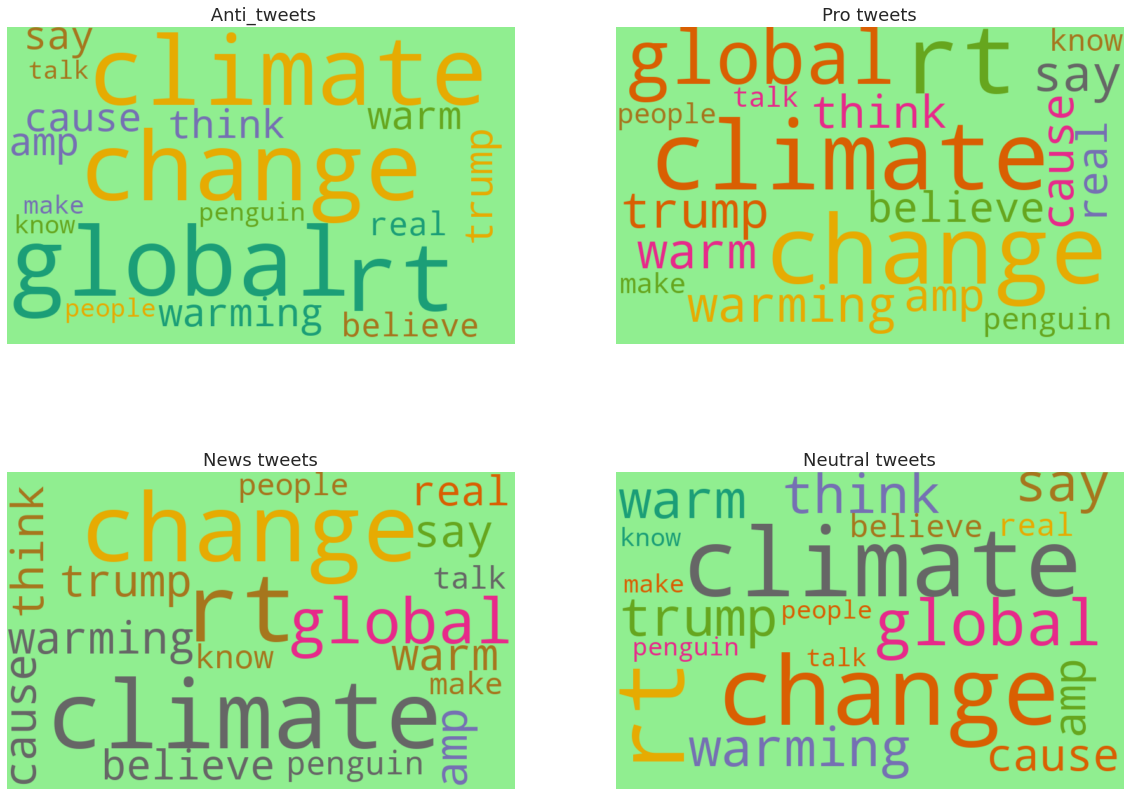

In [13]:
cloud = WordCloud(width=800, height=500, 
               background_color='lightgreen', colormap='Dark2',
               max_font_size=150, random_state=42)

plt.rcParams['figure.figsize'] = [20, 15]

# Create subplots 
for i in range(0, len(t_list)):
    cloud.generate(t_list[1])
    
    plt.subplot(2, 2, i + 1)
    plt.imshow(cloud, interpolation='bilinear')
    plt.axis("off")
    plt.title(titles[i])
    
    
plt.show()


# Lets have a look at the most popular organizations according to the information from our train data:

In [14]:
display(pro_ents.head())

,p,geopolitics,organizations
0,scott pruitt,america,epa
1,hillary clinton,china,nasa
2,don t,florida,gop
3,al gore,paris,exxon
4,don,california,the white house


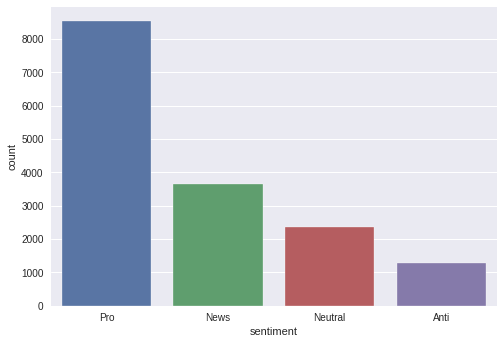

In [15]:
#visualize the distribution of each class

style.use('seaborn')

sns.countplot(df['sentiment'], data=df)

labels=['Pro', 'News', 'Neutral', 'Anti']


Taking a look at the above graph we can see that the data is imbalanced as most of the tweets are under the 'Pro' class

# Hashtag visualizations

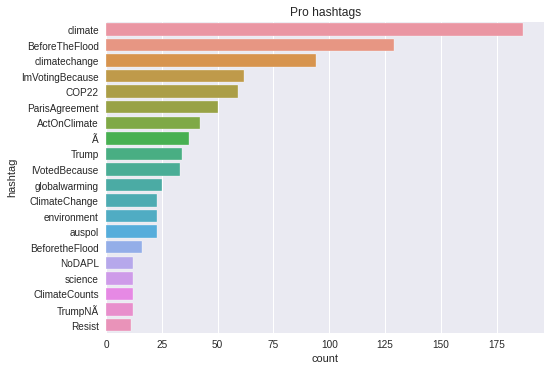

In [16]:
sns.barplot(data=pro,y=pro['hashtag'], x=pro['count'])
plt.title('Pro hashtags')
plt.tight_layout()

**A few important points to consider from the above** :

* One of the most popular hashtags is 'ActOnCLimate' where congressman Lieu calls on global citizens and the US Congress to #actonclimate. “This is a campaign that draws attention to the one issue that will define the contours of this century more dramatically than any other, and that is the urgent and growing threat of a changing climate.
* BeforeTheFlood - This is a 2016 documentary where U.N. messenger of peace for the climate Leonardo Dicaprio meets with a number of scientists and experts in order to find solutions to fight global warming.
* ParisAgreement - The Paris Agreement sets out a global framework to avoid dangerous climate change by limiting global warming to well below 2°C and pursuing efforts to limit it to 1.5°C. It also aims to strengthen countries’ ability to deal with the impacts of climate change and support them in their efforts.

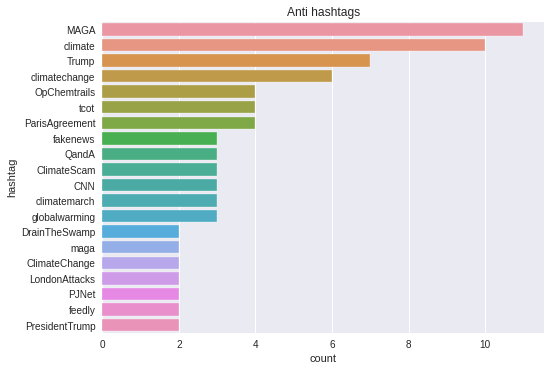

In [17]:
sns.barplot(data=anti,y=anti['hashtag'], x=anti['count'])
plt.title('Anti hashtags')
plt.tight_layout()

**A few important points to consider from the above** :

* MAGA (Make America Great Again) is the most popular hashtag from the Anti class.This is the slogan that Donal Trump used during his campaign for the elections of 2016.Donald Trump strongly believes that climate change does not exists so this is not a surprise (booo!!!)
* ClimateScam - This is a conspiracy theory where individuals claim that there is no evidence  that confirms that emission of greenhouse gases is harmful for the enviroment(really people??)
* DrainTheSwamp - Trump used this metaphor to describe his plan to fix problems in the federal government.During his presidential campaign, Trump claimed then that he would raise taxes on the wealthy, particularly the hedge fund managers.He vowed that he would take on the ‘power structure’ in Washington and ‘drain the swamp’ of all the lobbyists who had hurt the country’s working class. This is not a surprise as most of the Anti class hashtags relate to Trump and of course his followers supporting the non beliefs about climate change.








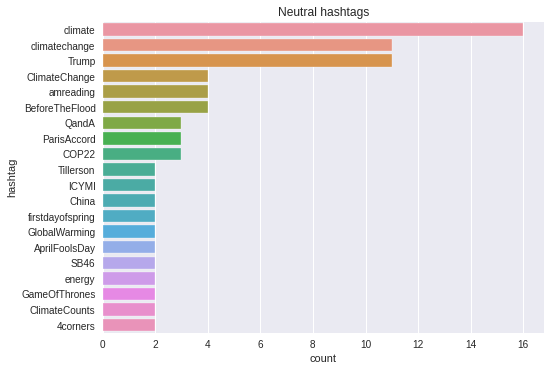

In [18]:
sns.barplot(data=neutral,y=neutral['hashtag'], x=neutral['count'])
plt.title('Neutral hashtags')
plt.tight_layout()

**A few important points to consider from the above**

* The tweets on this class tend to show a combination of everything as there is not a specific inclination to a subject or belief. We can see that on this class not all of the hashtags relate to enviromental concerns. some examples are GameOfThrones or firstdayofspring.

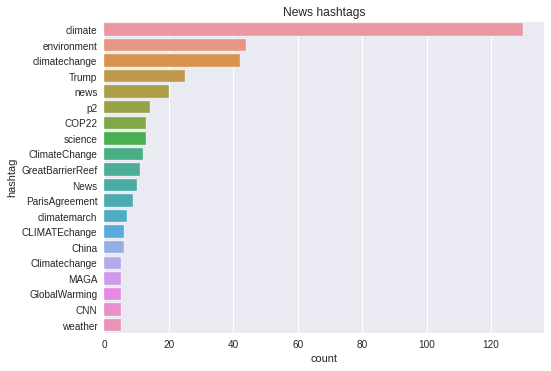

In [19]:
sns.barplot(data=news,y=news['hashtag'], x=news['count'])
plt.title('News hashtags')
plt.tight_layout()

**A few important points to consider from the above**

* News is one of the main source of information around the world and it's not a surprise that the hashtags found on this class are concentrating on targetting big organizations and their aim is to bring awareness to a group of individuals about the current issues on a given country and globally such as climate change.
* ClimateMarch - There are many protests held around the world both locally and internationally, these protests give an opportunity to highlight some of the main current issues such as discrimination ,enviromental issues or animal cruelty.

# Validation split

Ok so now that we have done our cleaning and data exploring its time to split the train data into features and targets in preparation for our model.

In [20]:
X = train ['message']
y = train ['sentiment']

#split the data
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.25, random_state=42)


# Building our models

We want to test different classification models in order to see which one works the best.
To do this we will make use of a pipeline.

The below models will be used for our predictions:

1. *Naive Bayes*
1. *Logistic Regression*
1. *Linear SVC*


In [21]:
# Naive Bayes
bayes = Pipeline([('tfidf', TfidfVectorizer()),
               ('clf', MultinomialNB())])
#Logistic Regression

lgr = Pipeline([('tfidf',TfidfVectorizer()),
               ('clf',LogisticRegression(C=1,
                                         class_weight='balanced', 
                                         max_iter=1000))])

#Linear SVC  

svc = Pipeline([('tfidf', TfidfVectorizer()),
                 ('clf', LinearSVC(class_weight='balanced'))])

In [22]:
#Lets train the models

bayes.fit(X_train, y_train)             #Naive bayes
y_pred_bayes = bayes.predict(X_val)


lgr.fit(X_train, y_train)               #Logistic Regression
y_pred_lgr = lgr.predict(X_val)


svc.fit(X_train, y_train)               #Linear SCV
y_pred_svc = svc.predict(X_val)

In [23]:
#Lets retrieve the F1- score for each model

f1_score(y_val, y_pred_bayes, average="macro")  #Naive bayes

0.33165251666780954

In [24]:
f1_score(y_val, y_pred_lgr, average="macro")    #Logistic Regression

0.6610227323582722

In [25]:
f1_score(y_val, y_pred_svc , average="macro")   #Linear SCV

0.677826820085863

Based on the above results we can agree that the SVC( Support Vector Classifier) model performed the best.

Lets review the confusion matrix of the above models :

In [26]:
print(metrics.classification_report(y_val, y_pred_bayes))

cm = confusion_matrix(y_val, y_pred_bayes)
cm_norm = cm / cm.sum(axis=1).reshape(-1,1)

              precision    recall  f1-score   support

          -1       0.00      0.00      0.00       336
           0       1.00      0.05      0.09       547
           1       0.60      0.99      0.75      2178
           2       0.94      0.33      0.48       894

    accuracy                           0.63      3955
   macro avg       0.63      0.34      0.33      3955
weighted avg       0.68      0.63      0.53      3955



/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [27]:
print(metrics.classification_report(y_val, y_pred_lgr))

cm = confusion_matrix(y_val, y_pred_lgr)
cm_norm = cm / cm.sum(axis=1).reshape(-1,1)

              precision    recall  f1-score   support

          -1       0.55      0.66      0.60       336
           0       0.50      0.56      0.53       547
           1       0.86      0.69      0.77      2178
           2       0.65      0.88      0.75       894

    accuracy                           0.71      3955
   macro avg       0.64      0.70      0.66      3955
weighted avg       0.74      0.71      0.72      3955



In [28]:
print(metrics.classification_report(y_val, y_pred_svc))

cm = confusion_matrix(y_val, y_pred_svc)
cm_norm = cm / cm.sum(axis=1).reshape(-1,1)

              precision    recall  f1-score   support

          -1       0.63      0.57      0.60       336
           0       0.57      0.49      0.53       547
           1       0.82      0.80      0.81      2178
           2       0.71      0.84      0.77       894

    accuracy                           0.75      3955
   macro avg       0.68      0.68      0.68      3955
weighted avg       0.74      0.75      0.74      3955



The model with the best accuracy is SVC achieving a score of 0.75 while the poorest model is 
Naive Bayes achieving a score of 0.63


In [29]:
#predicting on our test set

y_test = svc.predict(test['message'])

# Submission

In [30]:
final = pd.DataFrame({'tweetid':test['tweetid'],'sentiment':y_test})
final.to_csv('sample_submission.csv', index=False)

final

,tweetid,sentiment
0,169760,1
1,35326,1
2,224985,1
3,476263,1
4,872928,0
...,...,...
10541,895714,1
10542,875167,1
10543,78329,2
10544,867455,0


# Conclusions

Climate change is a real threat and if we don't take action now we will suffer the consequences. The information from the tweets dataset helped us determine that 74% of the tweets support the belief of man-made climate change, however, action to this is required or our efforts to educate others will be pointless.

Majority of the tweets against climate change come from Donald Trump and his followers. Trump is a strong and well educated person, however,enviromental issues are not part of his calendar and he sadly promotes that global warming is not real (are you blind?) which embraces his followers to do the same.

Linear SVC was the model that best classified the tweets from our dataset.

For more information about climate change and how you can help please click on this link:
https://www.un.org/en/actnow/

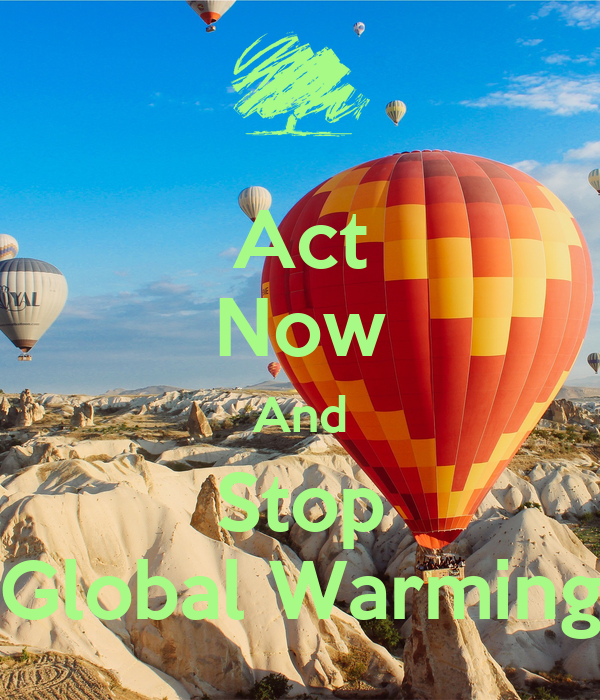